In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def analyze_performance_refactoring(file):
    # Read file
    df = pd.read_csv(file)

    # Filter rows with refactorings
    df_refact = df[df["refactorings"].notna()]

    # Create a list to store all refactoring-performance pairs
    results = []

    # Process each row
    for _, row in df_refact.iterrows():
        # Split refactorings
        refactorings = [r.strip() for r in row["refactorings"].split("+")]

        # Add each refactoring with its performance change
        for ref in refactorings:
            results.append({"refactoring_type": ref, "effect_size": row["effect_size"]})

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Remove outliers using IQR for each refactoring type
    def remove_outliers(group):
        Q1 = group["effect_size"].quantile(0.25)
        Q3 = group["effect_size"].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        return group[
            (group["effect_size"] >= lower_bound)
            & (group["effect_size"] <= upper_bound)
        ]

    results_df = results_df.groupby("refactoring_type", group_keys=False).apply(
        remove_outliers
    )

    # Calculate statistics for each refactoring type
    stats = results_df.groupby("refactoring_type")["effect_size"].describe()
    stats = stats[["count", "mean", "std", "min", "25%", "50%", "75%", "max"]]

    # Round all numeric columns to 3 decimal places
    stats = stats.round(3)

    # Save results
    stats.to_csv("../results/prq3-results.csv")

file = "../data/dataset_with_refactorings.csv"
analyze_performance_refactoring(file)

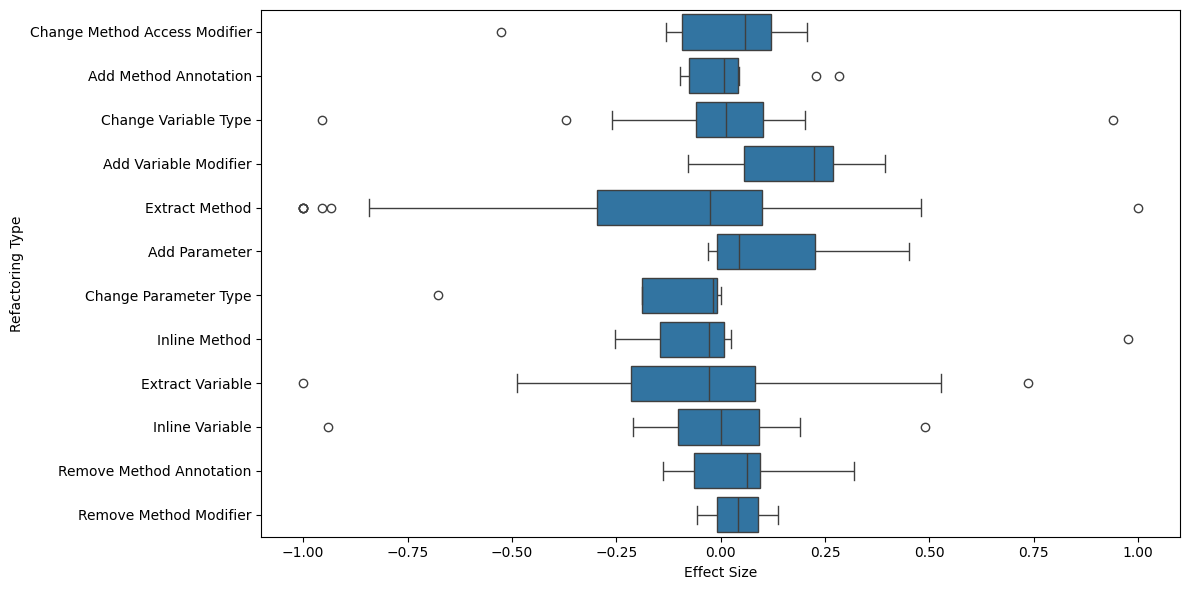

In [3]:
def create_performance_boxplot(file):
    # Read file
    df = pd.read_csv(file)

    # Filter rows with refactorings
    df_refact = df[df["refactorings"].notna()]

    # Create a list to store all refactoring-performance pairs
    results = []

    # Process each row
    for _, row in df_refact.iterrows():
        # Split refactorings
        refactorings = [r.strip() for r in row["refactorings"].split("+")]

        # Add each refactoring with its performance change
        for ref in refactorings:
            results.append({"refactoring_type": ref, "effect_size": row["effect_size"]})

    # Convert to DataFrame
    results_df = pd.DataFrame(results)

    # Create the box plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="effect_size", y="refactoring_type", data=results_df)
    # plt.title("Performance Change Distribution by Refactoring Type")
    plt.xlabel("Effect Size")
    plt.ylabel("Refactoring Type")

    # Adjust layout and save
    plt.tight_layout()
    plt.savefig("../figures/boxplot.pdf")
    plt.show()
    plt.close()

create_performance_boxplot(file)

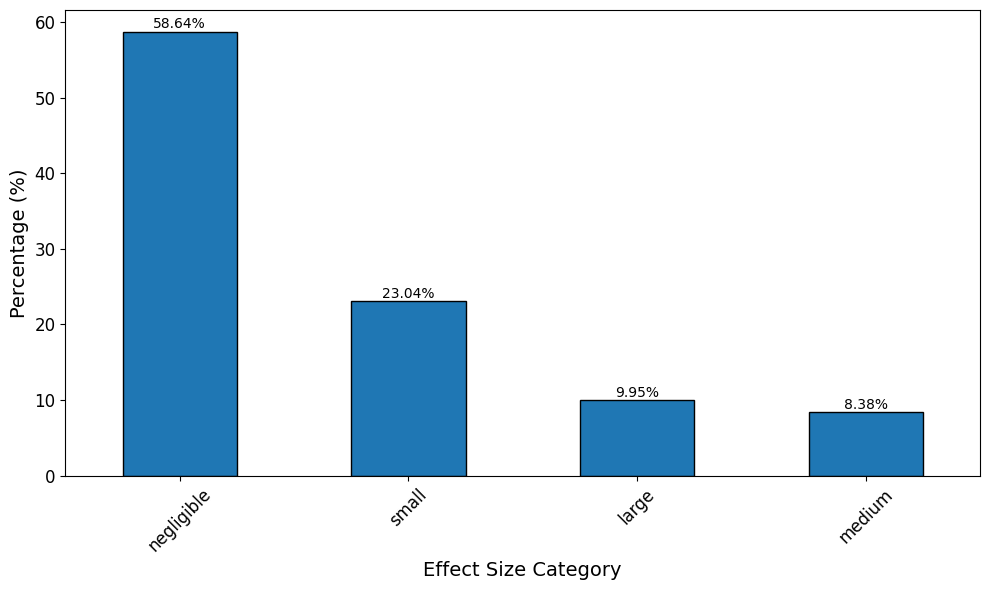

In [4]:
def plot_effect_size_interpretation(file):
    # Read the file
    df = pd.read_csv(file)

    # Ensure the column 'effect_size_interpretation' exists
    if "effect_size_interpretation" not in df.columns:
        raise ValueError(
            "The column 'effect_size_interpretation' is not present in the dataset."
        )

    # Calculate the percentage of each effect size interpretation
    interpretation_counts = (
        df["effect_size_interpretation"].value_counts(normalize=True) * 100
    )

    # Plot the bar graph
    plt.figure(figsize=(10, 6))
    interpretation_counts.plot(kind="bar", edgecolor="black")

    # Add titles and labels
    # plt.title("Percentage of Effect Size Interpretation", fontsize=16)
    plt.xlabel("Effect Size Category", fontsize=14)
    plt.ylabel("Percentage (%)", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)

    # Show percentages on top of bars
    for idx, value in enumerate(interpretation_counts):
        plt.text(idx, value + 0.5, f"{value:.2f}%", ha="center", fontsize=10)

    # Save the plot
    plt.tight_layout()
    # plt.savefig("effect_size_interpretation_percentage.pdf")
    plt.show()

plot_effect_size_interpretation(file)

In [29]:
def analyze_frequencies(refactoring_df: pd.DataFrame):
    """
    Analyze frequencies of refactorings and performance changes
    """
    # Initialize results dictionary
    frequencies = {
        "total_dataset": {},
        "refactoring_dataset": {},
        "overlap_analysis": {},
    }

    # 2. Refactoring Dataset Frequencies
    refactoring_methods = refactoring_df["method_id"].nunique()
    refactoring_commits = refactoring_df["commit_id"].nunique()
    refactoring_projects = refactoring_df["project_id"].nunique()

    # Count methods with performance changes
    perf_changes = refactoring_df[refactoring_df["effect_size"] != 0]
    methods_with_perf_changes = perf_changes["method_id"].nunique()

    frequencies["refactoring_dataset"] = {
        "methods_with_refactorings": refactoring_methods,
        "methods_with_perf_changes": methods_with_perf_changes,
        "commits_with_refactorings": refactoring_commits,
        "projects_with_refactorings": refactoring_projects,
    }

    # 3. Effect Size Distribution
    effect_size_dist = refactoring_df["effect_size_interpretation"].value_counts()
    frequencies["effect_size_distribution"] = effect_size_dist.to_dict()

    return frequencies

In [34]:
def generate_frequency_report(frequencies: dict):
    """
    Generate a detailed frequency report
    """
    report = []
    # report.append("Frequency Analysis of Refactorings and Performance Changes")
    # report.append("=" * 60)
        
    rd = frequencies["refactoring_dataset"]

    # Effect Size Distribution
    report.append("\n Effect Size Distribution:")
    for effect, count in frequencies["effect_size_distribution"].items():
        report.append(
            f"{effect}: {count} methods ({count/rd['methods_with_refactorings']*100:.2f}%)"
        )


    return "\n".join(report)

In [35]:
refactoring_performance_path = "../data/dataset_with_refactorings.csv"

refactoring_df = pd.read_csv(refactoring_performance_path)

refactoring_df["method_id"] = (
    refactoring_df["project_id"]
    + "/"
    + refactoring_df["commit_id"]
    + "/"
    + refactoring_df["method_name"]
)

# Perform frequency analysis
frequencies = analyze_frequencies(refactoring_df)

# Generate and print report
report = generate_frequency_report(frequencies)
print(report)


 Effect Size Distribution:
negligible: 112 methods (58.64%)
small: 44 methods (23.04%)
large: 19 methods (9.95%)
medium: 16 methods (8.38%)
